# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results, imputation_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [6]:
experiment = MIAExperiment(name='Census19')

In [7]:
save_model = True

print(f"Training classifier for experiment: {experiment}")
try:
    experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')
    print(f"Loaded classifier for experiment from file: {experiment}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment.clf = model_utils.get_model(max_iter=500)
    experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Census19_RAC1P_50_50_minority_categorized
Loaded classifier for experiment from file: Census19_RAC1P_50_50_minority_categorized


In [12]:
experiment.sensitive_column = experiment.ds.ds.meta['sensitive_column']
experiment.sensitive_positive = experiment.ds.ds.meta['sensitive_positive']
experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_te, experiment.clf)
sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
case_2_indices = case_indices[2]
experiment.case_2_indices = case_2_indices
experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]
experiment.sens_val_ground_truth = experiment.X_train[[f'{experiment.sensitive_column}_{experiment.sensitive_positive}']].to_numpy().ravel()
experiment.sens_pred = sens_pred

In [27]:
imputation_aux_dict = {}
aux_df = experiment.ds.ds.df.copy()

subgroup_col_name = 'ST'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()
for val in subgroup_vals:
    aux_df_sample = aux_df[aux_df[f"{subgroup_col_name}_{val}"]==1].copy()
    print(val)
    print(aux_df_sample.shape)
    if aux_df_sample.shape[0] > 500:
        imputation_aux_dict[val] = aux_df_sample.sample(n=500)

4
(11804, 109)
17
(1250, 109)
43
(8267, 109)
37
(1363, 109)
46
(2736, 109)
47
(2410, 109)
35
(3662, 109)
21
(2449, 109)
32
(6215, 109)
40
(1457, 109)
20
(2033, 109)
18
(1209, 109)
10
(3104, 109)
31
(541, 109)
19
(421, 109)
33
(3043, 109)
30
(2816, 109)
13
(3948, 109)
9
(6053, 109)
22
(2993, 109)
6
(1211, 109)
42
(2105, 109)
28
(878, 109)
14
(2102, 109)
38
(4093, 109)
24
(778, 109)
2
(2047, 109)
23
(1866, 109)
5
(1935, 109)
12
(552, 109)
7
(285, 109)
49
(1969, 109)
0
(1429, 109)
27
(624, 109)
44
(1056, 109)
11
(469, 109)
25
(1926, 109)
16
(964, 109)
15
(1040, 109)
48
(485, 109)
26
(332, 109)
39
(348, 109)
34
(257, 109)
8
(267, 109)
36
(1087, 109)
3
(782, 109)
29
(446, 109)
41
(316, 109)
1
(207, 109)
45
(202, 109)
50
(168, 109)


In [28]:
imputation_perf_dict = {}
for val in imputation_aux_dict:
    # print(val)
    condition = {subgroup_col_name: val}
    imputation_pred = imputation_attack(experiment, aux_df_onehot=imputation_aux_dict[val], subgroup_column='ST')
    imputation_perf_dict[val] = {}
    x_imputation, y_imputation, cols = experiment.ds.ds.get_x_y(imputation_aux_dict[val])
    X_imputation = pd.DataFrame(x_imputation, columns=cols)
    imputation_perf_dict[val]['group_correlation'] = get_corr_btn_sens_and_out_per_subgroup(experiment, X_imputation, y_imputation, condition)
    imputation_perf_dict[val]['marginal_prior'] = imputation_aux_dict[val]['MAR_0'].sum()/imputation_aux_dict[val].shape[0]
    # imputation_perf_dict[val]['marginal_prior_diff'] = np.abs(0.52 - imputation_perf_dict[val]['marginal_prior'])
    imputation_perf_dict[val]['imputation_accuracy'] = accuracy_score(experiment.sens_val_ground_truth, imputation_pred)
    # imputation_perf_dict[val]['imputation_accuracy_diff'] = 0.721169 - imputation_perf_dict[val]['imputation_accuracy']

In [25]:
get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, {})

0.18972873403006188

<Axes: xlabel='group_correlation', ylabel='imputation_accuracy'>

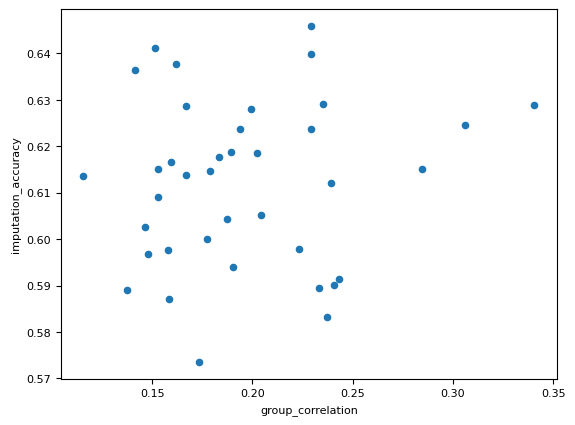

In [31]:
pd.DataFrame.from_dict(imputation_perf_dict, orient='index').sort_values(by='imputation_accuracy', ascending=True)[['group_correlation', 'imputation_accuracy']].plot(kind='scatter', x='group_correlation', y='imputation_accuracy')

In [50]:
get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, {})

-0.441171595477939

In [52]:
imputation_aux_dict = {}
aux_df = experiment.ds.ds.df.copy()

subgroup_col_name = 'work'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()
for val in subgroup_vals:
    aux_df_sample = aux_df[aux_df[f"{subgroup_col_name}_{val}"]==1].copy()
    print(val)
    print(aux_df_sample.shape)
    if aux_df_sample.shape[0] > 500:
        imputation_aux_dict[val] = aux_df_sample.sample(n=500)

Local-gov
(3100, 39)
Private
(33307, 39)
Federal-gov
(1406, 39)
Self-emp-inc
(1646, 39)
Self-emp-not-inc
(3796, 39)
State-gov
(1946, 39)
Without-pay
(21, 39)


In [55]:
imputation_perf_dict = {}
for val in imputation_aux_dict:
    # print(val)
    condition = {subgroup_col_name: val}
    imputation_pred = imputation_attack(experiment, aux_df_onehot=imputation_aux_dict[val], subgroup_column='occupation')
    imputation_perf_dict[val] = {}
    x_imputation, y_imputation, cols = experiment.ds.ds.get_x_y(imputation_aux_dict[val])
    X_imputation = pd.DataFrame(x_imputation, columns=cols)
    imputation_perf_dict[val]['group_correlation'] = get_corr_btn_sens_and_out_per_subgroup(experiment, X_imputation, y_imputation, condition)
    imputation_perf_dict[val]['marginal_prior'] = imputation_aux_dict[val]['marital_Single'].sum()/imputation_aux_dict[val].shape[0]
    imputation_perf_dict[val]['marginal_prior_diff'] = np.abs(0.52 - imputation_perf_dict[val]['marginal_prior'])
    imputation_perf_dict[val]['imputation_accuracy'] = accuracy_score(experiment.sens_val_ground_truth, imputation_pred)
    imputation_perf_dict[val]['imputation_accuracy_diff'] = 0.721169 - imputation_perf_dict[val]['imputation_accuracy']

pd.DataFrame.from_dict(imputation_perf_dict, orient='index').sort_values(by='imputation_accuracy', ascending=True)[['group_correlation', 'marginal_prior_diff', 'imputation_accuracy_diff']]

,group_correlation,marginal_prior_diff,imputation_accuracy_diff
Self-emp-not-inc,-0.247968,0.228,0.159475
Self-emp-inc,-0.342016,0.262,0.158083
Federal-gov,-0.510996,0.016,0.029783
Local-gov,-0.429299,0.052,0.018767
State-gov,-0.476325,0.022,0.014111
Private,-0.436894,0.038,0.010818


In [54]:
imputation_aux_dict[val].columns

Index(['fnlwgt', 'capitalgain', 'capitalloss', 'hoursperweek', 'income',
       'is_train', 'work_Federal-gov', 'work_Local-gov', 'work_Private',
       'work_Self-emp-inc', 'work_Self-emp-not-inc', 'work_State-gov',
       'work_Without-pay', 'education_edu1', 'education_edu2',
       'education_edu3', 'marital_Married', 'marital_Single',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_Female', 'sex_Male'],
      dtype='object')

In [ ]:
get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)

In [10]:
accuracy_score(experiment.sens_val_ground_truth, sens_pred)

0.699505990574073

In [11]:
pd.DataFrame.from_dict(imputation_perf_dict, orient='index')

,0.1,0.2,0.3,0.4,0.5
100,0.479615,0.577877,0.641644,0.714724,0.688377
500,0.544149,0.689455,0.715008,0.719834,0.734342
1000,0.601527,0.669298,0.705837,0.728948,0.718216
2500,0.584464,0.658253,0.701465,0.730055,0.734115
5000,0.625433,0.676850,0.715717,0.733065,0.734569


In [97]:
experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_te, experiment.clf)
sens_pred, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
case_2_indices = case_indices[2]
experiment.case_2_indices = case_2_indices
experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]
experiment.sens_val_ground_truth = experiment.X_train[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()
experiment.sens_pred = sens_pred

In [58]:
import itertools

def exhaustive_subgroup_search(X_train, y_tr, ds, experiment, sub_cols=['ST', 'COW', 'SEX', 'RAC1P']):
    sub_vals_dict = {i: ds.ds.original_df[i].unique().tolist() for i in sub_cols}
    # sub_vals_dict['ST'] = [50]
    all_subgroup_conditions = [{i: j for i, j in zip(sub_cols, j)} for j in list(itertools.product(*[sub_vals_dict[i] for i in sub_cols]))]
    angular_differences = []
    log_dict = {}
    for i in tqdm(range(len(all_subgroup_conditions))):
        cond = all_subgroup_conditions[i]
        try:
            indices = get_indices_by_group_condition(experiment.X_case_2, cond)
            angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
            angular_differences.append(angular_difference)
        except:
            angular_differences.append(0)
            continue
    
    # replace nan with 0 in stds
    angular_differences = np.nan_to_num(angular_differences)
    # get top k indices with highest std
    top_k_indices = np.argsort(angular_differences)[-300:]
    top_k_subgroup_conditions = [all_subgroup_conditions[i] for i in top_k_indices]
    for cond in top_k_subgroup_conditions:
        indices = get_indices_by_group_condition(experiment.X_train, cond)
        if indices.shape[0] < 20:
            continue
        try:
            count = len(indices)
            acc = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/count
            print(f'{cond}: {acc}, {count}, {angular_differences[np.argwhere(np.array(all_subgroup_conditions) == cond).ravel()[0]]}')
            log_dict[str(cond)] = {'acc': acc, 'count': count, 'corr': corr, 'std': angular_differences[np.argwhere(np.array(all_subgroup_conditions) == cond).ravel()[0]]}
        except:
            continue

    log_dict_df = pd.DataFrame.from_dict(log_dict, orient='index')
    return log_dict_df
        

In [ ]:
res_df = exhaustive_subgroup_search(experiment.X_train, experiment.y_tr, experiment.ds, experiment)

In [18]:
res_df

""


In [276]:
import re

def get_perf(input_string):

    # Use regular expression to extract the number inside parenthesis
    match = re.search(r'\(([\d.]+)\)', input_string)

    if match:
        extracted_number = match.group(1)
        return(float(extracted_number))
    else:
        return(np.nan)

sub_size_df = get_CSMIA_case_by_case_results(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds, 'ST', metric='accuracy', sensitive_col_name=None, subgroup_vals=list(range(51)))
csmia_res = sub_size_df.loc['Case All Cases'].to_numpy()[:-1]
csmia_res = np.array([get_perf(r) for r in csmia_res])

In [93]:
experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)

In [85]:
correlation_vs_ang_diff = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
for i in range(50):
    condition = {'ST': i}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, sens_pred, condition)
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['subgroup_val'] = i
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['correlation_prediction'] = correlation_prediction
    # correlation_vs_ang_diff[fcondition]['mutual_info'] = mutual_info
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
    # correlation_vs_ang_diff[fcondition]['influence'] = all_influences[fcondition]['importances_mean'][sensitive_column_index-1]/all_influences[fcondition]['importances_mean'].sum()
    # correlation_vs_ang_diff[fcondition]['highest_influence_index'] = np.argmax(all_influences[fcondition]['importances_mean'])    
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)

correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

In [88]:
state_vals_sorted = correlation_vs_ang_diff_df.sort_values(by='angular_difference', ascending=False)[['subgroup_val']].to_numpy().ravel()

In [137]:
targeted_attack_by_state_dict = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
for i in [1, 0.5, 0.25, 0.1, 0.05]:
    condition = {'ST': state_vals_sorted[:int(i * len(state_vals_sorted))].tolist()}
    fcondition = f'{condition}'
    targeted_attack_by_state_dict[fcondition] = {}
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    targeted_attack_by_state_dict[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)
    targeted_attack_by_state_dict[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_LOMIA[indices]).sum()/len(indices)
    targeted_attack_by_state_dict[fcondition]['frac_of_total_records'] = len(indices)/experiment.X_train.shape[0]
    case_2_indices = get_indices_by_group_condition(experiment.X_train.loc[experiment.case_2_indices], condition)
    targeted_attack_by_state_dict[fcondition]['CSMIA_case_2_attack_accuracy'] = (experiment.sens_val_ground_truth[case_2_indices] == experiment.sens_pred[case_2_indices]).sum()/len(case_2_indices)
    targeted_attack_by_state_dict[fcondition]['frac_of_total_records_case_2'] = len(case_2_indices)/experiment.X_train.shape[0]

targeted_attack_by_state_df = pd.DataFrame.from_dict(targeted_attack_by_state_dict, orient='index')

In [138]:
targeted_attack_by_state_df

,CSMIA_attack_accuracy,LOMIA_attack_accuracy,frac_of_total_records,CSMIA_case_2_attack_accuracy,frac_of_total_records_case_2
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21, 30, 27, 23, 22, 16, 19, 35, 12, 14, 18, 13, 11, 15, 17, 1, 7, 0, 10, 3, 4, 5, 8, 9, 2, 6]}",0.570667,0.607172,0.991447,0.566544,0.687309
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21]}",0.619460,0.670484,0.491222,0.628967,0.335091
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44]}",0.652682,0.707893,0.236651,0.665428,0.157000
"{'ST': [43, 48, 49, 47, 46]}",0.695788,0.724875,0.105584,0.721412,0.067960
"{'ST': [43, 48]}",0.703229,0.721604,0.039539,0.744449,0.024294


In [104]:
correlation_vs_ang_diff = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
subgroup_col_name = 'COW'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()
for i in subgroup_vals:
    condition = {subgroup_col_name: i, 'ST': state_vals_sorted[:int(0.25 * len(state_vals_sorted))].tolist()}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, sens_pred, condition)
    case_2_indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[case_2_indices], experiment.y_case_2[case_2_indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['subgroup_val'] = i
    correlation_vs_ang_diff[fcondition]['correlation_prediction'] = correlation_prediction
    # correlation_vs_ang_diff[fcondition]['mutual_info'] = mutual_info
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
    # correlation_vs_ang_diff[fcondition]['influence'] = all_influences[fcondition]['importances_mean'][sensitive_column_index-1]/all_influences[fcondition]['importances_mean'].sum()
    # correlation_vs_ang_diff[fcondition]['highest_influence_index'] = np.argmax(all_influences[fcondition]['importances_mean'])

    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)

correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

In [105]:
cow_vals_sorted = correlation_vs_ang_diff_df.sort_values(by='angular_difference', ascending=False)[['subgroup_val']].to_numpy().ravel()

In [139]:
import math
targeted_attack_by_state_and_cow_dict = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
for i in [1, 0.5, 0.25, 0.1, 0.05]:
    condition = {'ST': state_vals_sorted[:int(0.5 * len(state_vals_sorted))].tolist(), 'COW': cow_vals_sorted[:math.ceil(i * len(cow_vals_sorted))].tolist()}
    fcondition = f'{condition}'
    targeted_attack_by_state_and_cow_dict[fcondition] = {}
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    targeted_attack_by_state_and_cow_dict[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)
    targeted_attack_by_state_and_cow_dict[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_LOMIA[indices]).sum()/len(indices)
    case_2_indices = get_indices_by_group_condition(experiment.X_train.loc[experiment.case_2_indices], condition)
    targeted_attack_by_state_and_cow_dict[fcondition]['frac_of_total_records'] = len(indices)/experiment.X_train.shape[0]
    targeted_attack_by_state_and_cow_dict[fcondition]['CSMIA_case_2_attack_accuracy'] = (experiment.sens_val_ground_truth[case_2_indices] == experiment.sens_pred[case_2_indices]).sum()/len(case_2_indices)
    targeted_attack_by_state_and_cow_dict[fcondition]['frac_of_total_records_case_2'] = len(case_2_indices)/experiment.X_train.shape[0]

targeted_attack_by_state_and_cow_df = pd.DataFrame.from_dict(targeted_attack_by_state_and_cow_dict, orient='index')

In [140]:
targeted_attack_by_state_and_cow_df

,CSMIA_attack_accuracy,LOMIA_attack_accuracy,frac_of_total_records,CSMIA_case_2_attack_accuracy,frac_of_total_records_case_2
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2, 4, 1, 3, 6]}",0.619460,0.670484,0.491222,0.628967,0.335091
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2]}",0.630692,0.680272,0.370546,0.643531,0.249628
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7]}",0.639987,0.693358,0.308750,0.655033,0.212577
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0]}",0.640469,0.693689,0.307143,0.655565,0.211531


In [128]:
correlation_vs_ang_diff = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
subgroup_col_name = 'SEX'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()
for i in subgroup_vals:
    condition = {subgroup_col_name: i, 'ST': state_vals_sorted[:int(0.5 * len(state_vals_sorted))].tolist(), 'COW': cow_vals_sorted[:math.ceil(0.5 * len(cow_vals_sorted))].tolist()}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, sens_pred, condition)
    case_2_indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[case_2_indices], experiment.y_case_2[case_2_indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['frac_of_total_records'] = len(indices)/experiment.X_train.shape[0]
    # targeted_attack_by_state_and_cow_dict[fcondition]
    correlation_vs_ang_diff[fcondition]['subgroup_val'] = i
    correlation_vs_ang_diff[fcondition]['correlation_prediction'] = correlation_prediction
    # correlation_vs_ang_diff[fcondition]['mutual_info'] = mutual_info
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
    # correlation_vs_ang_diff[fcondition]['influence'] = all_influences[fcondition]['importances_mean'][sensitive_column_index-1]/all_influences[fcondition]['importances_mean'].sum()
    # correlation_vs_ang_diff[fcondition]['highest_influence_index'] = np.argmax(all_influences[fcondition]['importances_mean'])

    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)
    correlation_vs_ang_diff[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_LOMIA[indices]).sum()/len(indices)
    case_2_indices = get_indices_by_group_condition(experiment.X_train.loc[experiment.case_2_indices], condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_case_2_attack_accuracy'] = (experiment.sens_val_ground_truth[case_2_indices] == experiment.sens_pred[case_2_indices]).sum()/len(case_2_indices)


correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

In [129]:
correlation_vs_ang_diff_df

,correlation,frac_of_total_records,subgroup_val,correlation_prediction,angular_difference,CSMIA_attack_accuracy,LOMIA_attack_accuracy,CSMIA_case_2_attack_accuracy
"{'SEX': 1, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2]}",-0.224383,0.222902,1,0.118565,0.244589,0.557221,0.633490,0.543127
"{'SEX': 0, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2]}",-0.418015,0.147644,0,0.344042,0.417597,0.679358,0.711259,0.718941


In [130]:
correlation_vs_ang_diff = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
subgroup_col_name = 'WAOB'
subgroup_vals = experiment.ds.ds.original_df[subgroup_col_name].unique()
for i in subgroup_vals:
    condition = {subgroup_col_name: i, 'ST': state_vals_sorted[:int(0.5 * len(state_vals_sorted))].tolist(), 'COW': cow_vals_sorted[:math.ceil(0.5 * len(cow_vals_sorted))].tolist(), 'SEX': 0}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, sens_pred, condition)
    case_2_indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[case_2_indices], experiment.y_case_2[case_2_indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['frac_of_total_records'] = len(indices)/experiment.X_train.shape[0]
    # targeted_attack_by_state_and_cow_dict[fcondition]
    correlation_vs_ang_diff[fcondition]['subgroup_val'] = i
    correlation_vs_ang_diff[fcondition]['correlation_prediction'] = correlation_prediction
    # correlation_vs_ang_diff[fcondition]['mutual_info'] = mutual_info
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
    # correlation_vs_ang_diff[fcondition]['influence'] = all_influences[fcondition]['importances_mean'][sensitive_column_index-1]/all_influences[fcondition]['importances_mean'].sum()
    # correlation_vs_ang_diff[fcondition]['highest_influence_index'] = np.argmax(all_influences[fcondition]['importances_mean'])

    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)
    # correlation_vs_ang_diff[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_LOMIA[indices]).sum()/len(indices)
    # case_2_indices = get_indices_by_group_condition(experiment.X_train.loc[experiment.case_2_indices], condition)
    # correlation_vs_ang_diff[fcondition]['CSMIA_case_2_attack_accuracy'] = (experiment.sens_val_ground_truth[case_2_indices] == experiment.sens_pred[case_2_indices]).sum()/len(case_2_indices)


correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

In [131]:
correlation_vs_ang_diff_df

,correlation,frac_of_total_records,subgroup_val,correlation_prediction,angular_difference,CSMIA_attack_accuracy
"{'WAOB': 0, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.429197,0.222902,0,0.356469,0.424137,0.685029
"{'WAOB': 2, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.247679,0.200425,2,0.169212,0.426649,0.573438
"{'WAOB': 3, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.347108,0.007045,3,0.272637,0.400915,0.673212
"{'WAOB': 4, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.290835,0.007848,4,0.220395,0.268370,0.652062
"{'WAOB': 1, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.228475,0.004271,1,-0.060632,-0.258069,0.473684
"{'WAOB': 5, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.248274,0.000627,5,0.211462,0.353918,0.605042
"{'WAOB': 6, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.456172,0.001310,6,0.309261,0.816120,0.712766
"{'WAOB': 7, 'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'SEX': 0}",-0.381542,0.001035,7,0.160357,0.447508,0.580645


In [132]:
waob_vals_sorted = correlation_vs_ang_diff_df.sort_values(by='angular_difference', ascending=False)[['subgroup_val']].to_numpy().ravel()

In [141]:
import math
targeted_attack_by_waob_dict = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
for i in [1, 0.5, 0.25, 0.1, 0.05]:
    condition = {'ST': state_vals_sorted[:int(0.5 * len(state_vals_sorted))].tolist(), 'COW': cow_vals_sorted[:math.ceil(0.5 * len(cow_vals_sorted))].tolist(), 'WAOB': waob_vals_sorted[:math.ceil(i * len(cow_vals_sorted))].tolist(), 'SEX': 0}
    fcondition = f'{condition}'
    targeted_attack_by_waob_dict[fcondition] = {}
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    targeted_attack_by_waob_dict[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred[indices]).sum()/len(indices)
    targeted_attack_by_waob_dict[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_LOMIA[indices]).sum()/len(indices)
    case_2_indices = get_indices_by_group_condition(experiment.X_train.loc[experiment.case_2_indices], condition)
    targeted_attack_by_waob_dict[fcondition]['frac_of_total_records'] = len(indices)/experiment.X_train.shape[0]
    targeted_attack_by_waob_dict[fcondition]['CSMIA_case_2_attack_accuracy'] = (experiment.sens_val_ground_truth[case_2_indices] == experiment.sens_pred[case_2_indices]).sum()/len(case_2_indices)
    targeted_attack_by_waob_dict[fcondition]['frac_of_total_records_case_2'] = len(case_2_indices)/experiment.X_train.shape[0]

targeted_attack_by_waob_df = pd.DataFrame.from_dict(targeted_attack_by_waob_dict, orient='index')

In [142]:
targeted_attack_by_waob_df

,CSMIA_attack_accuracy,LOMIA_attack_accuracy,frac_of_total_records,CSMIA_case_2_attack_accuracy,frac_of_total_records_case_2
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'WAOB': [6, 7, 2, 0, 3, 5, 4, 1], 'SEX': 0}",0.679358,0.711259,0.222902,0.718941,0.142558
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'WAOB': [6, 7, 2, 0], 'SEX': 0}",0.681231,0.712750,0.208846,0.721079,0.132641
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'WAOB': [6, 7], 'SEX': 0}",0.680000,0.752000,0.001376,0.634409,0.001024
"{'ST': [43, 48, 49, 47, 46, 42, 36, 45, 34, 38, 37, 44, 41, 31, 29, 33, 40, 39, 32, 28, 25, 20, 26, 24, 21], 'COW': [0, 7, 5, 2], 'WAOB': [6], 'SEX': 0}",0.712766,0.755319,0.001035,0.656716,0.000738


In [339]:
correlation_vs_ang_diff = {}
sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
for i in range(50):
    condition = {'ST': i}
    fcondition = f'{condition}'
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, sens_pred, condition)
    indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['correlation_prediction'] = correlation_prediction
    # correlation_vs_ang_diff[fcondition]['mutual_info'] = mutual_info
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
    # correlation_vs_ang_diff[fcondition]['influence'] = all_influences[fcondition]['importances_mean'][sensitive_column_index-1]/all_influences[fcondition]['importances_mean'].sum()
    # correlation_vs_ang_diff[fcondition]['highest_influence_index'] = np.argmax(all_influences[fcondition]['importances_mean'])
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = csmia_res[i]
    correlation_vs_ang_diff[fcondition]['LOMIA_attack_accuracy'] = lomia_res_dict[i]
    correlation_vs_ang_diff[fcondition]['baseline_attack_accuracy'] = baseline_res[i]

In [243]:
def plot_comparison(correlation_vs_ang_diff_df, x_axis_col_name='correlation', y_axis_col_name='attack_accuracy'):
    arr = correlation_vs_ang_diff_df[[x_axis_col_name, y_axis_col_name]].to_numpy()

    x_values = [item[0] for item in arr]
    y_values = [item[1] for item in arr]

    # Creating the scatter plot
    fig, ax = plt.subplots()
    plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
    # plt.title('Scatter Plot of Correlation vs Angular Difference')
    plt.xlabel(f'{x_axis_col_name.replace("_", " ")}')
    plt.ylabel(f'{y_axis_col_name}')
    # plt.xlim(-0.5, 0.025)
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # sns.despine()
    plt.show()


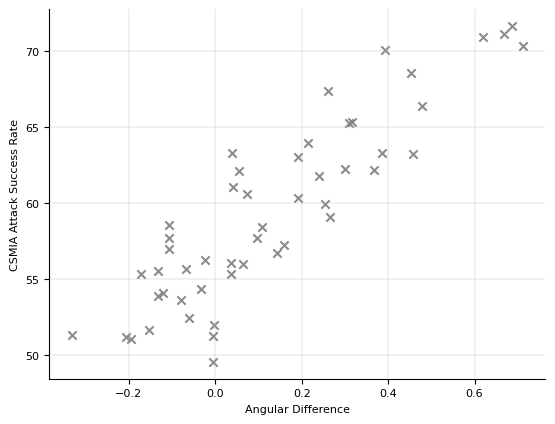

In [344]:
arr = correlation_vs_ang_diff_df[['angular_difference', "CSMIA_attack_accuracy"]].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Angular Difference')
plt.ylabel(f'CSMIA Attack Success Rate')
# plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

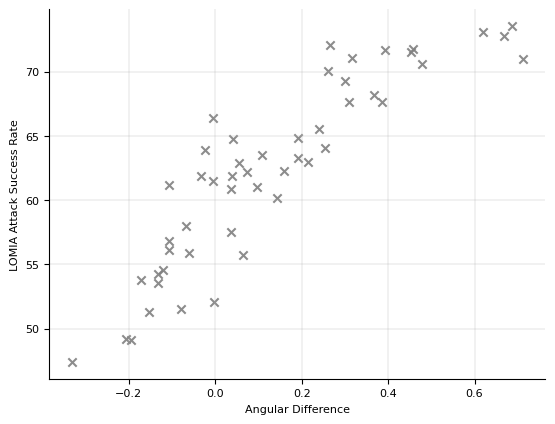

In [343]:
arr = correlation_vs_ang_diff_df[['angular_difference', "LOMIA_attack_accuracy"]].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Angular Difference')
plt.ylabel(f'LOMIA Attack Success Rate')
# plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

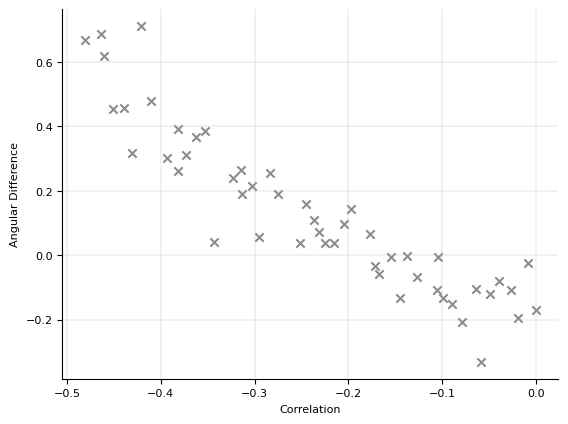

In [345]:
arr = correlation_vs_ang_diff_df[['correlation', "angular_difference"]].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Correlation')
plt.ylabel(f'Angular Difference')
# plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

In [320]:
'x_y'.replace('_', ' ')

'x y'

In [341]:
correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

In [342]:
correlation_vs_ang_diff_df

,correlation,correlation_prediction,angular_difference,CSMIA_attack_accuracy,LOMIA_attack_accuracy,baseline_attack_accuracy
{'ST': 0},0.000000,0.106155,-0.170662,55.3000,53.8000,49.8328
{'ST': 1},-0.007849,0.098920,-0.024537,56.2257,63.9105,44.9541
{'ST': 2},-0.019000,0.021039,-0.193907,51.0500,49.1000,46.8584
{'ST': 3},-0.027007,0.116553,-0.107850,57.6974,56.7763,52.9172
{'ST': 4},-0.039000,0.072000,-0.079379,53.6000,51.5500,50.1673
{'ST': 5},-0.049000,0.081522,-0.121616,54.0500,54.5500,50.8406
{'ST': 6},-0.059000,0.026017,-0.331418,51.3000,47.4000,44.0263
{'ST': 7},-0.063470,0.122311,-0.106313,58.5432,61.1981,44.8276
{'ST': 8},-0.079000,0.024066,-0.207083,51.2000,49.1500,30.5556
{'ST': 9},-0.089000,0.032318,-0.152020,51.6000,51.3000,54.1796


In [318]:
attacks = ['CSMIA', 'LOMIA']
metrics = [kendalltau, spearmanr]
metric_name_dict = {
    kendalltau: 'Kendall Tau',
    spearmanr: 'Spearman R'
}

ranking_perf_dict = {}
for attack in attacks:
    ranking_perf_dict[attack] = {}
    for metric in metrics:
        ranking_perf_dict[attack][metric_name_dict[metric]] = {}

        for dia in ['angular_difference', 'baseline_attack_accuracy']:
            ranking_perf = metric(correlation_vs_ang_diff_df[[f'{attack}_attack_accuracy']].to_numpy(), correlation_vs_ang_diff_df[[dia]].to_numpy())
            ranking_perf_dict[attack][metric_name_dict[metric]][dia] = f'{round(ranking_perf.statistic, 4)} ({ranking_perf.pvalue:.2e})'
            # x_values = correlation_vs_ang_diff[[f'{attack}_attack_accuracy']].to_numpy()
            # ranking_perf_dict[attack][metric][dia] = metric(x_values, x_values)

In [319]:
ranking_perf_dict

{'CSMIA': {'Kendall Tau': {'angular_difference': '0.6914 (1.39e-12)',
   'baseline_attack_accuracy': '-0.0759 (4.37e-01)'},
  'Spearman R': {'angular_difference': '0.8767 (7.23e-17)',
   'baseline_attack_accuracy': '-0.1225 (3.97e-01)'}},
 'LOMIA': {'Kendall Tau': {'angular_difference': '0.7579 (8.30e-15)',
   'baseline_attack_accuracy': '-0.0931 (3.40e-01)'},
  'Spearman R': {'angular_difference': '0.9104 (5.06e-20)',
   'baseline_attack_accuracy': '-0.1275 (3.77e-01)'}}}

In [315]:
f"{ranking_perf.pvalue:.2e}"

'1.39e-12'

In [309]:
ranking_perf_dict

{'CSMIA': {'<function kendalltau at 0x1277929d0>': {'angular_difference': SignificanceResult(statistic=0.6914285714285714, pvalue=1.3900963709598425e-12),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.07591836734693877, pvalue=0.43660923632935034)},
  '<function spearmanr at 0x1277928b0>': {'angular_difference': SignificanceResult(statistic=0.8766866746698678, pvalue=7.232312722148806e-17),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.1224969987995198, pvalue=0.39673069234463554)}},
 'LOMIA': {'<function kendalltau at 0x1277929d0>': {'angular_difference': SignificanceResult(statistic=0.7578604143440391, pvalue=8.3035518660684e-15),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.0930992319345048, pvalue=0.3402724081290214)},
  '<function spearmanr at 0x1277928b0>': {'angular_difference': SignificanceResult(statistic=0.9103699971410856, pvalue=5.0555002063792164e-20),
   'baseline_attack_accuracy': SignificanceResult(statistic=-0.1275420

In [271]:
correlation_vs_ang_diff_df.columns

Index(['correlation', 'mutual_info', 'angular_difference', 'influence',
       'attack_accuracy'],
      dtype='object')

In [257]:
def compute_ranking_matrix(df, ranking_fun=kendalltau):
    ranking_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

    # Compute pairwise Kendall's tau correlations
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                ranking_matrix.loc[col1, col2] = 1.0
            else:
                tau, p_value = ranking_fun(df[col1], df[col2])
                ranking_matrix.loc[col1, col2] = tau

    # Convert the results to float type
    ranking_matrix = ranking_matrix.astype(float)
    return ranking_matrix

In [268]:
compute_ranking_matrix(correlation_vs_ang_diff_df)

,correlation,mutual_info,angular_difference,influence,attack_accuracy
correlation,1.000000,-0.998367,-0.794286,-0.382857,-0.707755
mutual_info,-0.998367,1.000000,0.792653,0.381224,0.709388
angular_difference,-0.794286,0.792653,1.000000,0.418776,0.691429
influence,-0.382857,0.381224,0.418776,1.000000,0.368163
attack_accuracy,-0.707755,0.709388,0.691429,0.368163,1.000000


In [269]:
compute_ranking_matrix(correlation_vs_ang_diff_df, spearmanr)

,correlation,mutual_info,angular_difference,influence,attack_accuracy
correlation,1.000000,-0.999904,-0.941801,-0.512893,-0.879184
mutual_info,-0.999904,1.000000,0.941224,0.511837,0.880048
angular_difference,-0.941801,0.941224,1.000000,0.559088,0.876687
influence,-0.512893,0.511837,0.559088,1.000000,0.519328
attack_accuracy,-0.879184,0.880048,0.876687,0.519328,1.000000


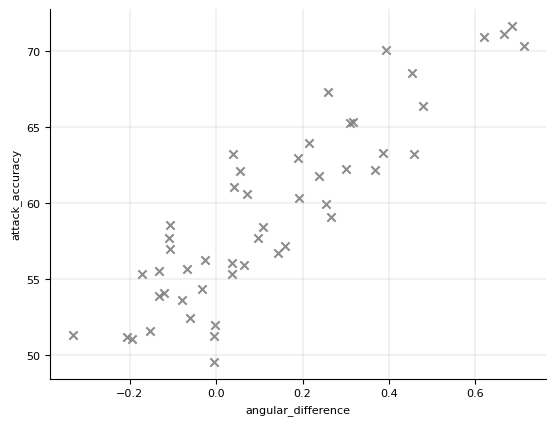

In [273]:
plot_comparison(correlation_vs_ang_diff_df, 'angular_difference', 'attack_accuracy')

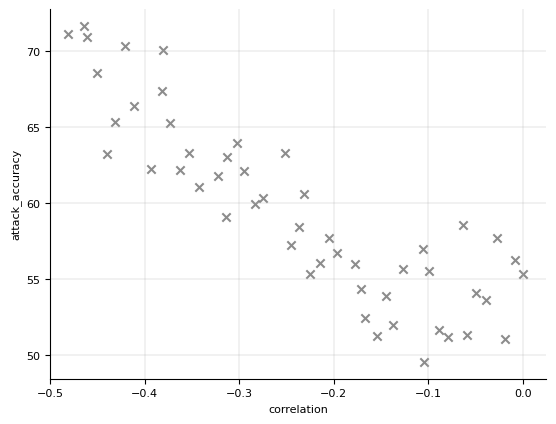

In [241]:
plot_comparison(correlation_vs_ang_diff_df)

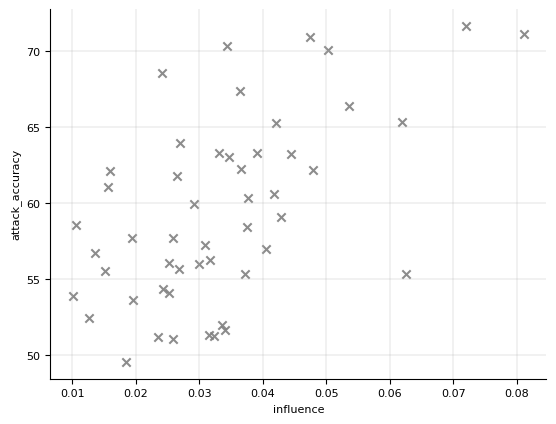

In [250]:
plot_comparison(correlation_vs_ang_diff_df, x_axis_col_name='influence')

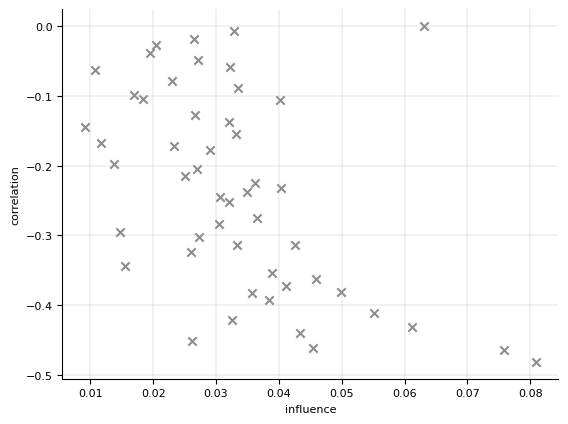

In [274]:
plot_comparison(correlation_vs_ang_diff_df, x_axis_col_name='influence', y_axis_col_name='correlation')

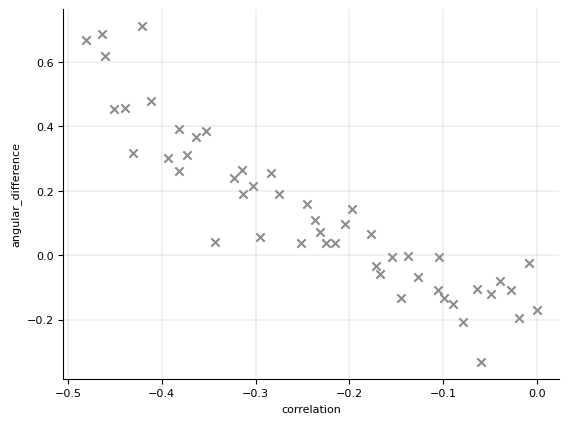

In [246]:
plot_comparison(correlation_vs_ang_diff_df, y_axis_col_name='angular_difference')

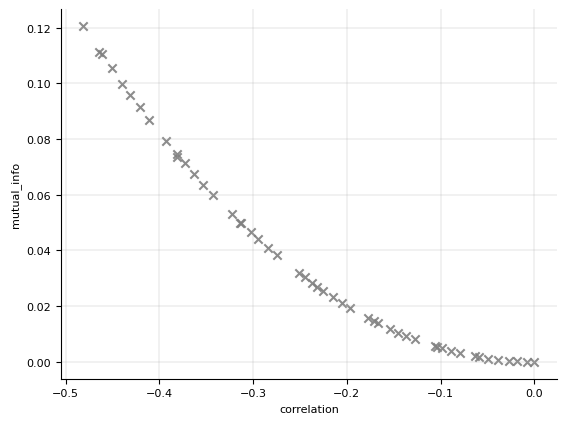

In [270]:
plot_comparison(correlation_vs_ang_diff_df, 'correlation', 'mutual_info')

In [252]:
tau, tau_p_value = kendalltau(x_values, y_values)

# Calculate Spearman's Rank Correlation
spearman_corr, spearman_p_value = spearmanr(x_values, y_values)

print("Kendall's Tau:", tau, "with p-value:", tau_p_value)
print("Spearman's Rank Correlation:", spearman_corr, "with p-value:", spearman_p_value)

NameError: name 'kendalltau' is not defined

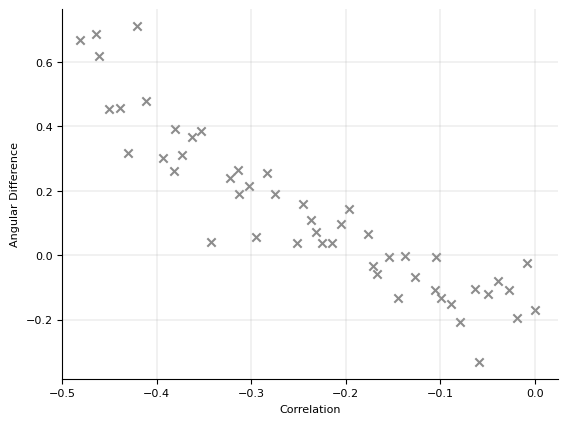

In [167]:
correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')
arr = correlation_vs_ang_diff_df[['correlation', 'angular_difference']].to_numpy()

x_values = [item[0] for item in arr]
y_values = [item[1] for item in arr]

# Creating the scatter plot
fig, ax = plt.subplots()
plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
# plt.title('Scatter Plot of Correlation vs Angular Difference')
plt.xlabel('Correlation')
plt.ylabel('Angular Difference')
plt.xlim(-0.5, 0.025)
plt.grid(True, linewidth=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# sns.despine()
plt.show()

In [346]:
def draw_conf_scatter_for_state(state_index=0, num_points=300):
    indices = get_indices_by_group_condition(experiment.X_case_2, {'ST': state_index})
    draw_confidence_array_scatter(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices], num_points)

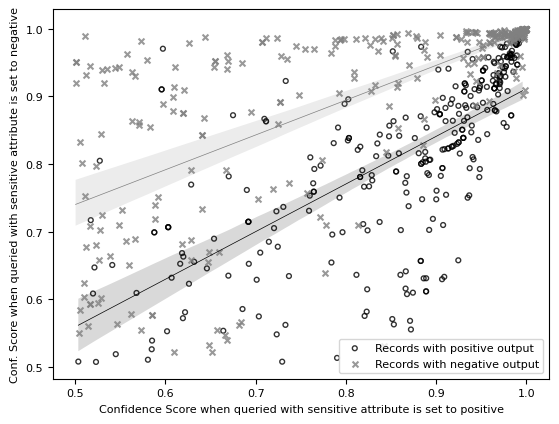

In [352]:
draw_conf_scatter_for_state()

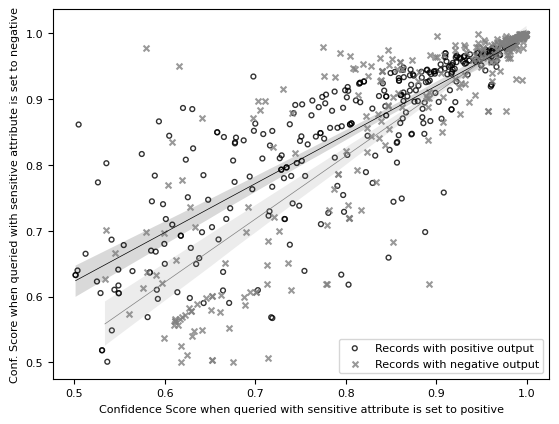

In [353]:
draw_conf_scatter_for_state(state_index=25)

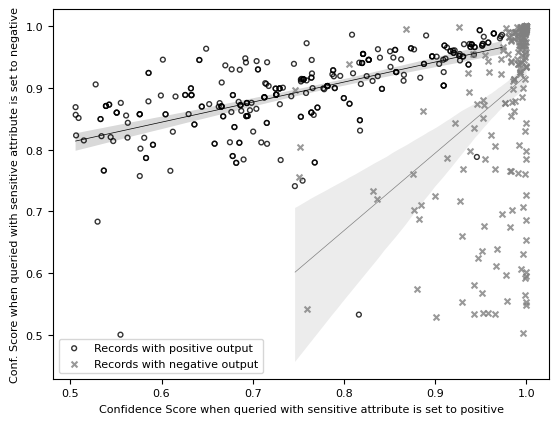

In [354]:
draw_conf_scatter_for_state(state_index=50)